# Predicting Heart Disease Through Classification with Health Indicators

Yiyao Ru, 
Liam Sissons,
Nizel Abalos,
Sebastian Yeo

## 1. Introduction

   “Heart disease” refers to a varying number of heart related conditions that may include arrhythmias, heart attack, or even heart failure. There are several risk factors that may contribute to the development of heart disease including unhealthy lifestyle, genetics, smoking, and more. In particular, high blood pressure and high cholesterol are main factors that may contribute to the development of heart disease (About heart disease 2022).
   
  Using the “Heart Disease Data Set” from UCI’s Machine Learning Repository, this data analysis explores the relationship between heart disease and several variables including cholesterol, age, maximum heart rate and rest/exercise induced ST depression using a classification model. These quantitative variables were chosen based on exploration of their relationships with heart disease risk through visualizations. The variables that showed a trend in relation to heart disease risk were chosen, while those that showed little variation in values between risk levels were dismissed. The specific data set from Cleveland was chosen due to the prevalence of heart disease related to lifestyle and health factors in the United States (U.S. health care from a global perspective, 2019: Higher spending, worse outcomes? 2020). The dataset includes health related test results collected from about 300 patients in Cleveland and originates from the Cleveland Clinic Foundation. 
  
  Each of the chosen variables is a health indicator which appears to influence risk level of heart disease. Cholesterol is a measurement of lipids in the blood, and age relates to years lived. Maximum heart rate looks at how high of a heart rate an individual can achieve, usually through exercise, and may indicate heart fitness. ST depression describes an abnormally low portion of the ST segment (area between QRS complex and T wave) on an electrocardiogram (ECG) reading (Rowden, 2022). ST depression may indicate several heart related health conditions. 
  
   A classification model was created which classifies the chosen variables to be used to predict heart disease risk. The data analysis and classification aims to answer the question: To what extent can the risk level of heart disease (no risk, low risk, or high risk) be predicted using the collected Cleveland data on health variables including cholesterol, age, maximum heart rate, and ST depression induced by rest/exercise?



## 2. Methods and Results

### 2.1 Reading the data

Required libraries are loaded below.

In [14]:
library(tidyverse)
library(repr)
library(tidymodels)
library(cowplot)
library(GGally)

The "Heart Disease Data Set" from the UCI Machine Learning Repository is read in as a csv file using the appropriate read function.

In [15]:
processed_cleveland_hd <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data", col_names = FALSE)

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


### 2.2 Preliminary Data Analysis

Column names are assigned to the unnamed columns based on those given by the UCI Machine Learning Repository and the data set is displayed in Table 1. Some of the column names are slightly modified to be more human readable.

In [16]:
colnames(processed_cleveland_hd) <- c("age", "sex", "chestpain", "rest_bloodpressure", "chol", "fast_sugar", "restecg", "maxhr", "ex_anigna", "st_depression", "slope", "num_vessels", "thal", "num")
head(processed_cleveland_hd)

age,sex,chestpain,rest_bloodpressure,chol,fast_sugar,restecg,maxhr,ex_anigna,st_depression,slope,num_vessels,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0


_Table 1: Read Data_

The original data assigned risk levels from 0-4 based on risk level, with 0 being no indication of heart disease, and 4 being high risk. The risk categories of the dataset were mutated into three categories: no risk (0), low risk (1-2) and high risk (3-4). This was done to reduce the amount of risk categories (5 being too many) and to make these numbered risk levels easier to understand. The risk level was also mutated to be a factor and is displayed in the table below. In addition, some observations did not have any value for the num_vessels variables and were removed from the data set.

In [17]:
hd_selected <- processed_cleveland_hd |>
    mutate(risk = ifelse(num == 0, "No Risk", ifelse(num >= 3, "High Risk", "Low Risk"))) |>
    select(-num) |>
    mutate(risk = as_factor(risk), num_vessels = as.double(num_vessels), thal = as.double(thal)) |>
    filter(!is.na(num_vessels)) |>
    filter(!is.na(thal))
head(hd_selected)

Warning message:
"There were 2 warnings in `mutate()`.
The first warning was:
ℹ In argument: `num_vessels = as.double(num_vessels)`.
Caused by warning:
! NAs introduced by coercion
ℹ Run `dplyr::last_dplyr_warnings()` to see the 1 remaining warning."


age,sex,chestpain,rest_bloodpressure,chol,fast_sugar,restecg,maxhr,ex_anigna,st_depression,slope,num_vessels,thal,risk
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0,6,No Risk
67,1,4,160,286,0,2,108,1,1.5,2,3,3,Low Risk
67,1,4,120,229,0,2,129,1,2.6,2,2,7,Low Risk
37,1,3,130,250,0,0,187,0,3.5,3,0,3,No Risk
41,0,2,130,204,0,2,172,0,1.4,1,0,3,No Risk
56,1,2,120,236,0,0,178,0,0.8,1,0,3,No Risk


_Table 2: Cleaned Data_

The data is split into two groups: training and testing. Strata is assigned to be the column risk, which is what will be predicted. The split uses 75% of the data for training and 25% of the data for testing. The training data will be used to train the model. The model will then be tested on the testing data.

In [18]:
#Splitting the data into a training and testing data set
set.seed(1234)

hd_split <- initial_split(hd_selected, prop = 0.75, strata = risk)
hd_train <- training(hd_split)
hd_test <- testing(hd_split)

Data exploration is done to determine which variables will be the best for the classification model. The average values for each risk level are tabulated in order to better understand the distribution of points within each category.

In [19]:
hd_predictors_train <- hd_train |>
    group_by(risk) |>
    summarize(across(age:thal, mean))|>
    arrange(risk)

hd_observations <- hd_train |>
    group_by(risk) |>
    summarise(count = n())

hd <- merge(hd_predictors_train, hd_observations, on = "risk")

distinct(hd)


risk,age,sex,chestpain,rest_bloodpressure,chol,fast_sugar,restecg,maxhr,ex_anigna,st_depression,slope,num_vessels,thal,count
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
High Risk,56.44444,0.8611111,3.694444,135.4444,243.4444,0.1666667,1.3055556,132.5278,0.6111111,2.0416667,2.027778,1.5000000,6.138889,36
Low Risk,57.03030,0.8181818,3.545455,134.6970,255.2727,0.1212121,1.0757576,139.5909,0.5151515,1.3924242,1.712121,0.9848485,5.560606,66
No Risk,52.33333,0.5583333,2.783333,129.2000,243.8667,0.1500000,0.8416667,158.8500,0.1416667,0.5466667,1.391667,0.2833333,3.866667,120


_Table 3: Data Means Explored_

Some of the mean values for each variable differ, but that does not show how the distributions in each risk level look like. Visualization can help demonstrate the correlation of each variable and their risk level.

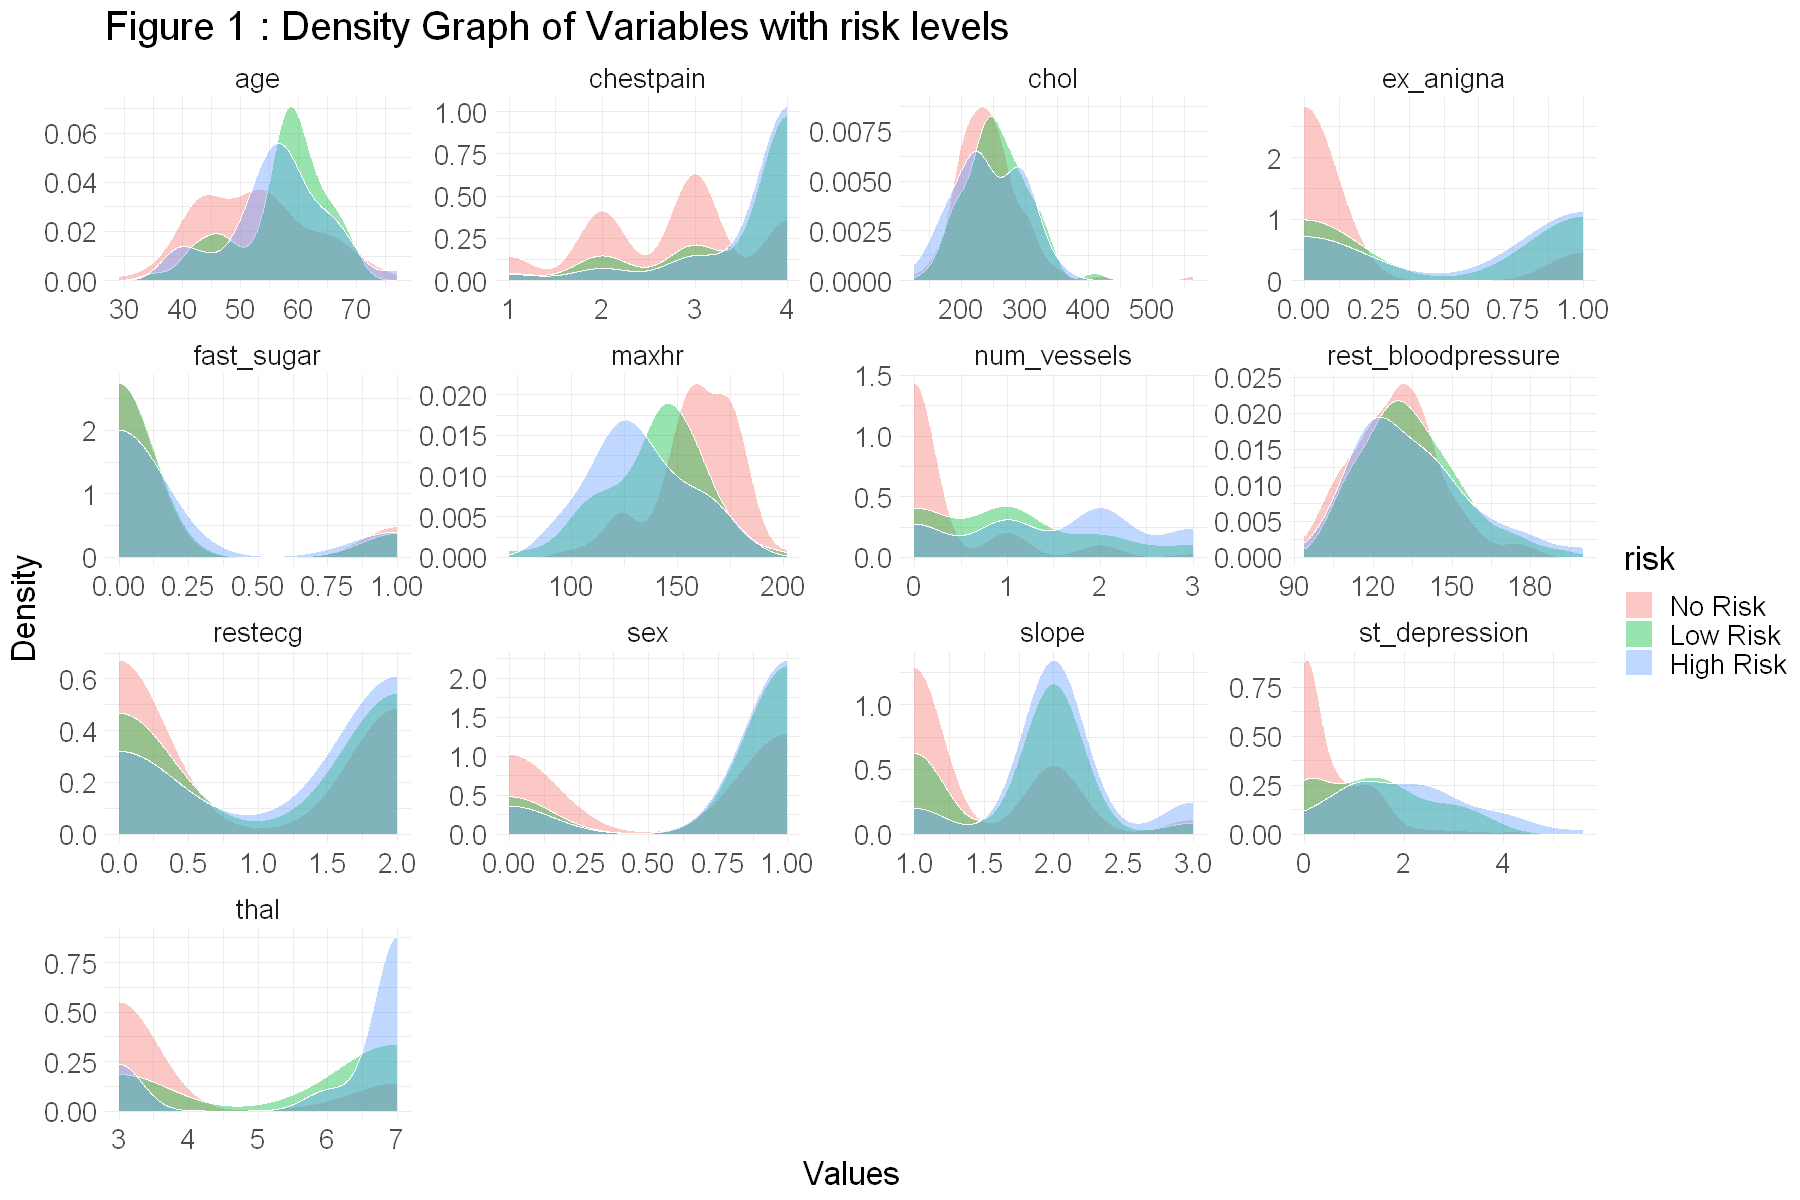

In [38]:
options(repr.plot.width = 15, repr.plot.height = 10)
hd_plot <- hd_train |>
    pivot_longer(cols = -risk, names_to = "category", values_to = "value") |>
    ggplot(aes(value, fill = risk)) +
    geom_density(alpha = 0.4, colour = "white") +
    facet_wrap(facets = vars(category), scales = "free") +
    theme_minimal() +
    theme(text = element_text(size = 20)) +
    ggtitle("Figure 1 : Density Graph of Variables with risk levels") +
    labs(x = "Values", y = "Density")
hd_plot

From Table 3 and Figure 1, we can determine that variables that have little to no correlation are cholesterol levels(chol), fasting blood sugar being greater than 120 mg (fast_sugar), and resting blood pressure (rest_bloodpressure). The other variables show distinct distributions for the level of risks and can be used to train the model. For example, the chest pain levels are lower for those that do not have any risk in heart diseask, while it is higher for those that do have a risk of heart disease. Looking at the mean levels of chest pain for each risk category, the ones with low or high risk have a higher level than those with no risk. Similar analysis was done to the other variables, and so the variables chosen to train the model were age (age), level of chestpain (chestpain), exersice induced anigna (ex_anigna), max heart rate achieved (maxhr), number of major vessels colored by fluoroscopy (num_vessels), resting electrocardiographic results (restecg), sex (sex), the slope of the peak exercise ST segment (slope), ST depression induced by exercise relative to rest (st_depression), and the type of thalassemia (thal). 

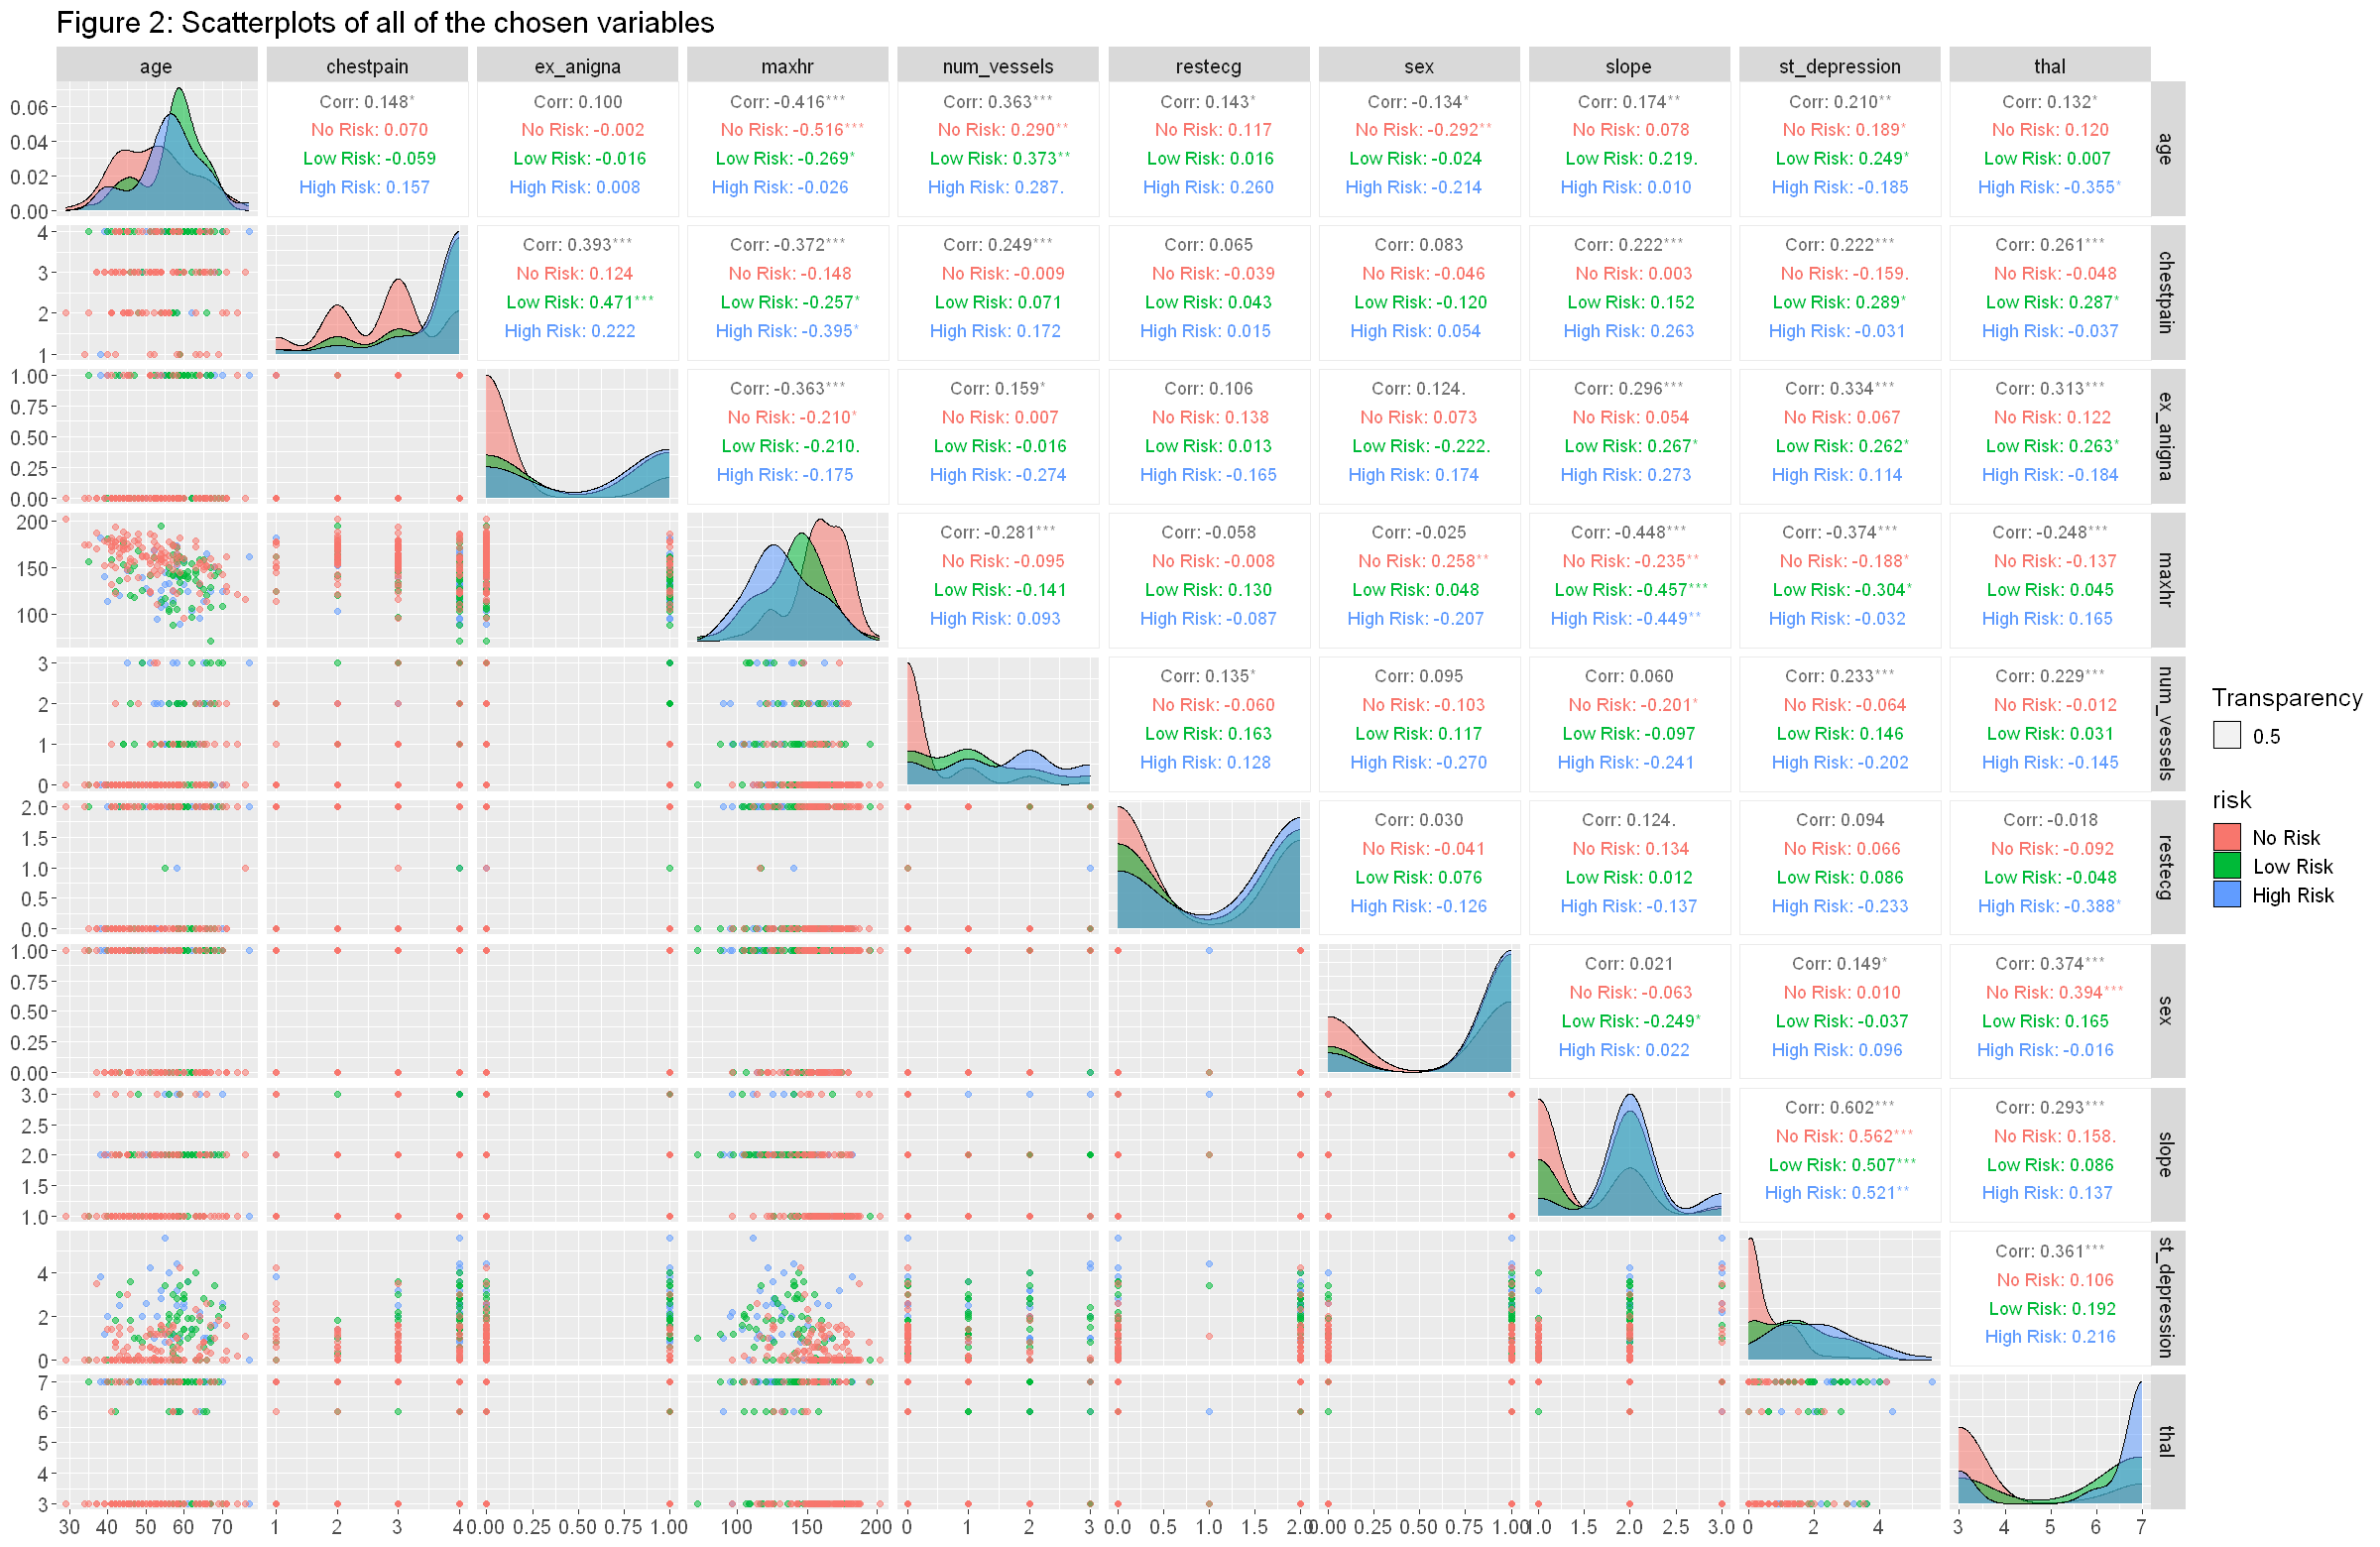

In [54]:
options(repr.plot.width = 20, repr.plot.height = 13)
hd_pairs <- hd_train |>
    select(age, chestpain, ex_anigna, maxhr, num_vessels, restecg, sex, slope, st_depression, thal, risk) |>
    ggpairs(columns = 1:10, aes(color = risk, alpha = 0.5), legend = c(1, 1)) +
    labs(alpha = "Transparency", color = "Risk") +
    theme(legend.position = "right", text = element_text(size =15)) +
    ggtitle("Figure 2: Scatterplots of all of the chosen variables")
hd_pairs

Looking at the scatterplots from Figure 2, the "grouping" or clustering of the risk gorups can be seen in the selected variables, which further show that they are variables that can train the model. That being said, the highest amount of clustering were observed in the maxhr vs st_depression and slope vs st_depression plots which will be used to determine if the model is classifying the test set accurately..

### 2.3 Building the Model

The classification model is created below. A recipe assigns risk as a combination of the selected variables (age, ST depression, maximum heart rate and cholesterol) and the predictors are all scaled. Since the value of k might influence the accuracy of the model, various values of K are tested to determine the optimal k value using cross validation. 10 folds were used in the cross validation because that value produced the most precise results (less variation in K values). Finally, we filter for accuracy.

In [22]:
set.seed(2023)
k_vals <- tibble(neighbors = seq(from = 1, to = 50, by = 1))
hd_recipe <- recipe(risk ~ age + chestpain + ex_anigna + num_vessels + restecg + sex + slope + st_depression + thal, data = hd_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())
knn_tune <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")
hd_vfold <- vfold_cv(hd_train, v = 10, strata = risk)
hd_tune <- workflow() |>
                  add_recipe(hd_recipe) |>
                  add_model(knn_tune) |>
                  tune_grid(resamples = hd_vfold, grid=k_vals) |>
                  collect_metrics()
hd_accuracies <- hd_tune |>
    filter(.metric == "accuracy")

A visualization of neighbors vs. accuracy estimate is produced in Figure 2 to identify the best K value. From the graph, the highest accuracy (about 69%) is acheived by a K value of 41.

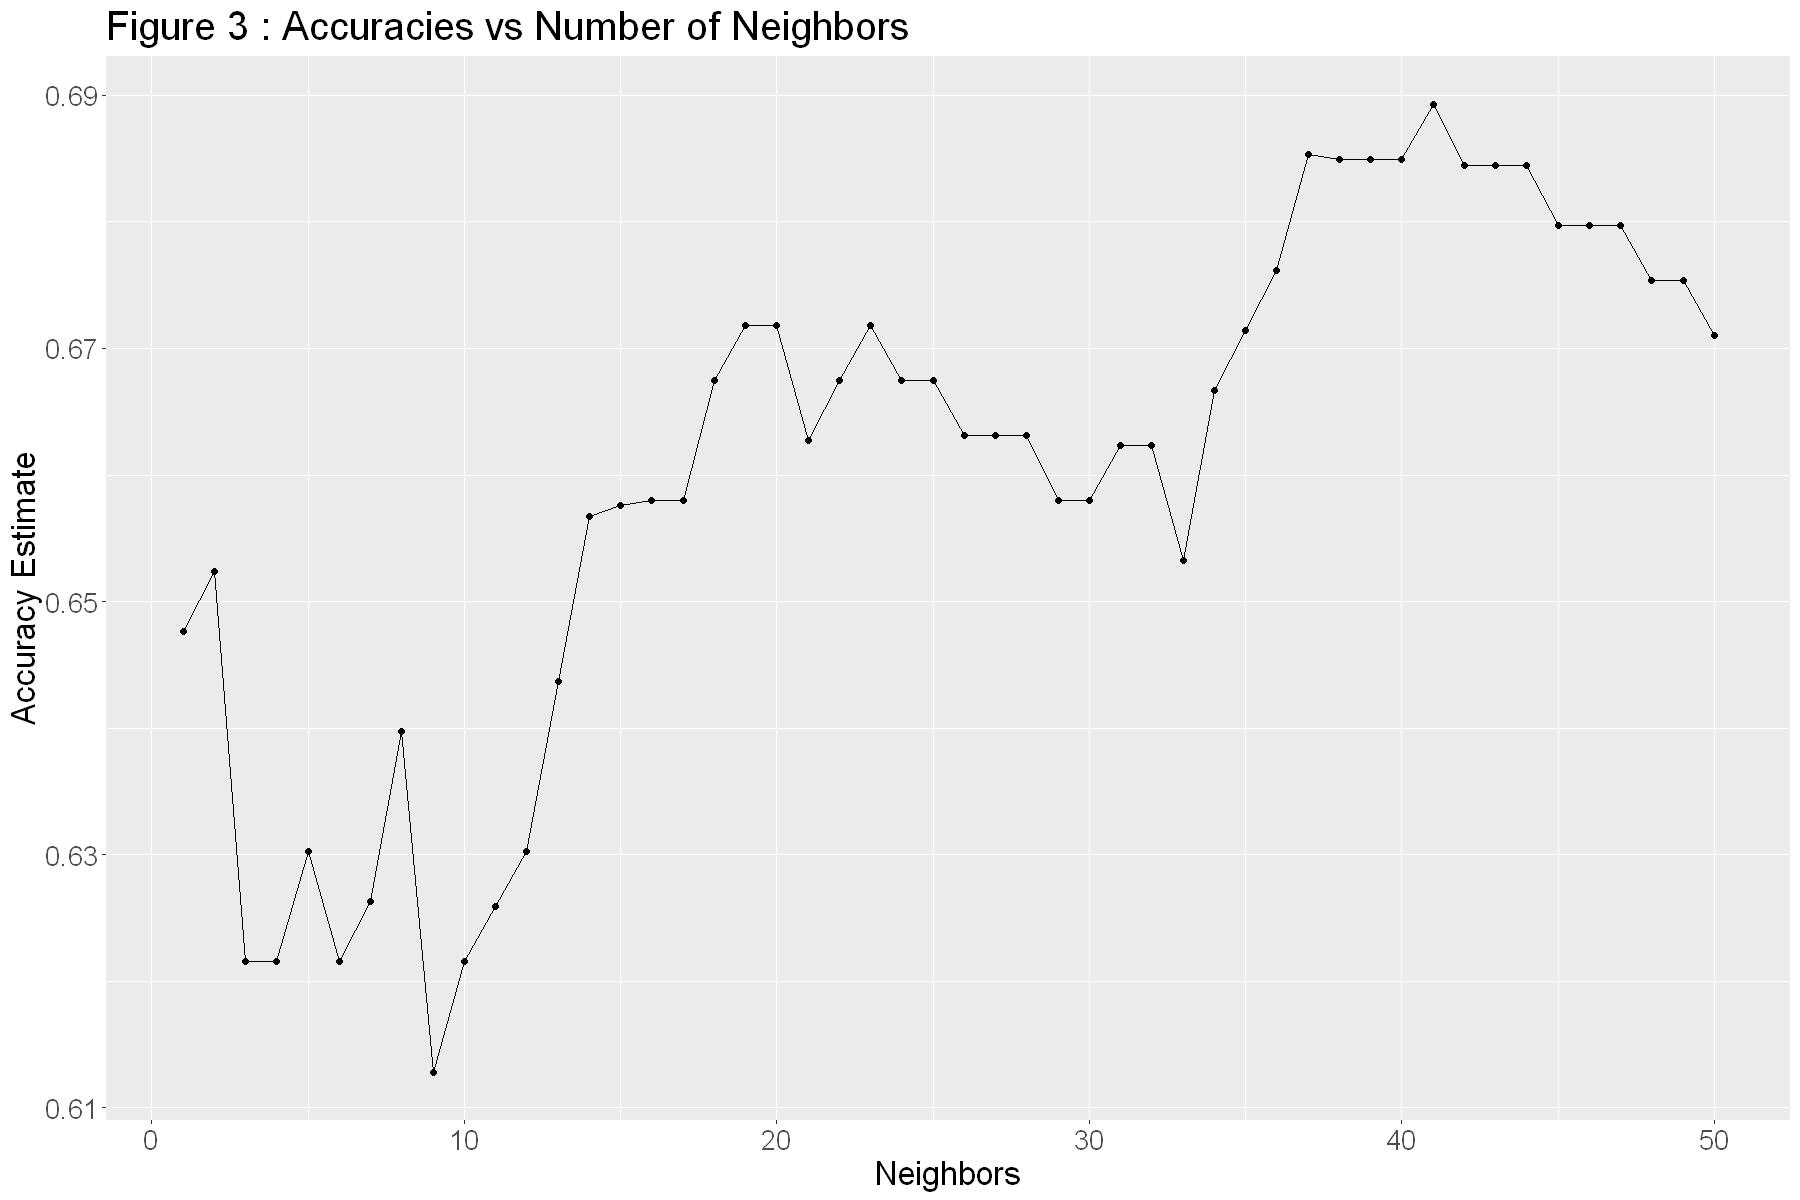

In [27]:
options(repr.plot.width = 15, repr.plot.height = 10)
knn_plot <- ggplot(hd_accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") +
  theme(text = element_text(size = 20)) +
  ggtitle("Figure 3 : Accuracies vs Number of Neighbors")
knn_plot

Using the best K value which was obtained above, the classification model is trained. Then, the predict function is used and the overall accuracy is displayed. As shown in Table 4 the K value of 41 has an accuracy of 68% with the testing set.

In [24]:
k_selected <- hd_accuracies |>
    arrange(desc(mean)) |>
    slice(1) |>
    select(neighbors) |>
    pull()
k_selected
knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = k_selected) |>
  set_engine("kknn") |>
  set_mode("classification")
knn_fit <- workflow() |>
    add_recipe(hd_recipe) |>
    add_model(knn_spec) |>
    fit(data = hd_train)
hd_predictions <- predict(knn_fit, hd_test) |>
  bind_cols(hd_test)
hd_predictions |>
  metrics(truth = risk, estimate = .pred_class) |>
  filter(.metric == "accuracy")

[1] 41

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.68


_Table 4: Accuracy of Classification Model_

A confusion matrix was created to look at the model's predictions. The model did not identify every risk category correctly, but it shows a general prediction ability with the majority of predictions for each category being correct.

In [25]:
heart_conf_mat <- hd_predictions |>
conf_mat(truth = risk, estimate = .pred_class)
heart_conf_mat

           Truth
Prediction  No Risk Low Risk High Risk
  No Risk        39       11         1
  Low Risk        1       12        11
  High Risk       0        0         0

_Table 5: Confusion Matrix for Classification Model_

## 3. Discussion

## 4. Works Cited

About heart disease. Centers for Disease Control and Prevention. (2022, July 12). Retrieved …March 2, 2023, from https://www.cdc.gov/heartdisease/about.htm 

Robert, D. Heart Disease Data Set. UCI Machine Learning Repository. Retrieved March 2, …2023, from https://archive.ics.uci.edu/ml/datasets/Heart+Disease 

Rowden, A. (July, 2022). St depression on ECG: What it means and causes. Medical News …Today. from https://www.medicalnewstoday.com/articles/st-depression-on-ecg 

U.S. health care from a global perspective, 2019: Higher spending, worse outcomes? U.S. Health …Care from a Global Perspective, 2019 | Commonwealth Fund. (2020, January 30). Retrieved …March 2, 2023, from …https://www.commonwealthfund.org/publications/issue-briefs/2020/jan/us-health-care-global-p…erspective-2019#:~:text=More%20than%20one%2Dquarter%20of,less%20in%20all%20other…%20countries 
